# Garbage Classification (Machine Learning only)
- Feature extraction: Bag of Word + Color Histogram
- Data Augmentation
- Dimensionality reduction: PCA


In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### Load dataset

In [3]:
W, H = IMG_SIZE = (128, 128)

DATASET_PATH = "/mnt/c/Users/PC/PycharmProjects/garbage_classification/garbage-dataset"

#Lấy danh sách tất cả các folder
classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes found:", classes)

X_images, y_labels = [], []

for label in tqdm(classes, desc="Loading dataset"):
    folder = os.path.join(DATASET_PATH, label)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        #Đọc ảnh
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        #Chuẩn hóa ảnh về dạng BGR 3 kênh
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        X_images.append(img)
        y_labels.append(label)

X_images = np.array(X_images, dtype=np.uint8)
y_labels = np.array(y_labels)
print("Loaded:", X_images.shape, y_labels.shape)

Classes found: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


Loading dataset: 100%|██████████| 10/10 [03:25<00:00, 20.56s/it]


Loaded: (19762, 128, 128, 3) (19762,)


##### Visualization Data Input

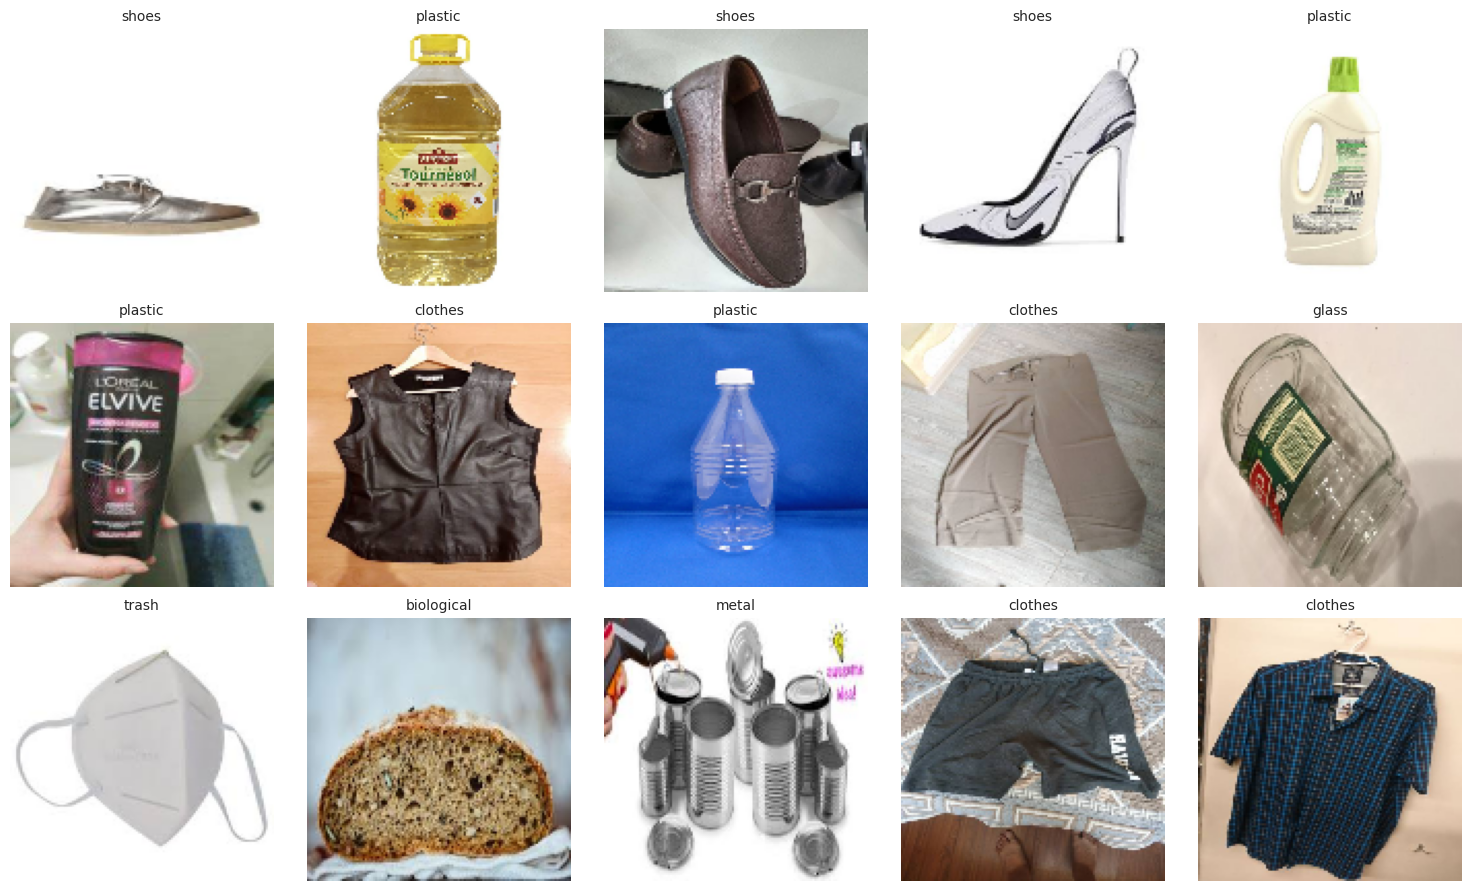

In [4]:
def visualize_random_samples(X, y, samples=15, cols=5):
    rows = (samples + cols - 1) // cols
    plt.figure(figsize=(15, 3 * rows))

    indices = random.sample(range(len(X)), samples)

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)

        img_rgb = cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB)

        plt.imshow(img_rgb)
        plt.title(f"{y[idx]}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_samples(X_images, y_labels)

##### Distribution

/tmp/ipykernel_17305/1708090181.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=unique, y=counts, palette="viridis")


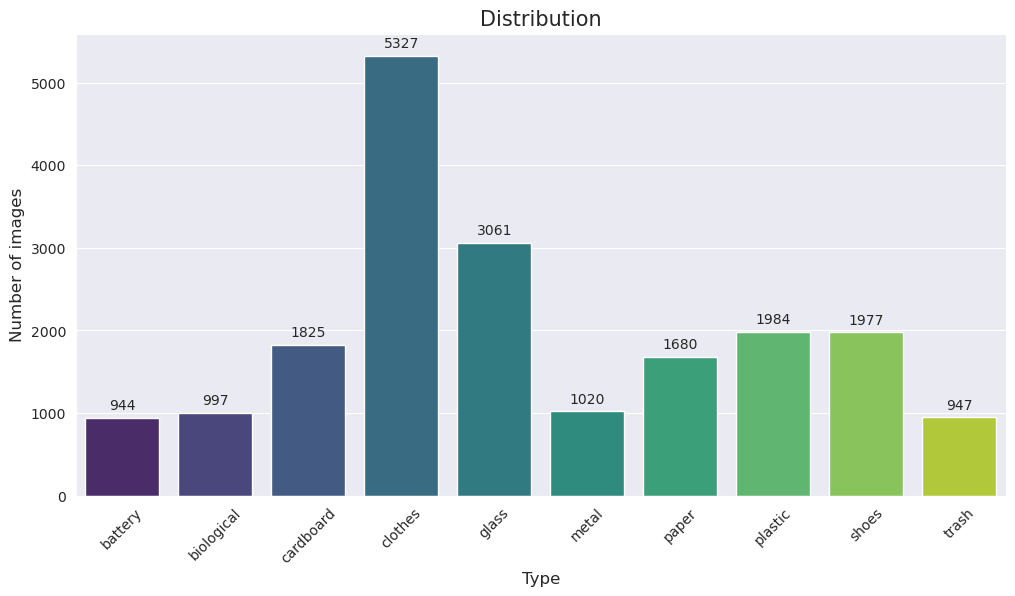

In [6]:
def plot_distribution(y):
    plt.figure(figsize=(12, 6))

    unique, counts = np.unique(y, return_counts=True)

    ax = sns.barplot(x=unique, y=counts, palette="viridis")

    plt.title("Distribution", fontsize=15)
    plt.xlabel("Type", fontsize=12)
    plt.ylabel("Number of images", fontsize=12)
    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')
    plt.show()

plot_distribution(y_labels)

#### Train/Test split

In [7]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_images, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

Train: (15809, 128, 128, 3) Test: (3953, 128, 128, 3)


#### Data augmentation

In [8]:
def augment_image(img):
    img = cv2.resize(img, IMG_SIZE)
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((W//2, H//2), angle, 1)
    img = cv2.warpAffine(img, M, (W, H))
    factor = 0.7 + np.random.rand() * 0.6
    img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    return img

X_train_aug = []
y_train_aug = []

for img, label in zip(X_train_raw, y_train_raw):
    X_train_aug.append(img)
    y_train_aug.append(label)
    for _ in range(2):
        #Tạo 2 ảnh tăng cường cho mỗi ảnh gốc nhưng vẫn giữ nguyên nhãn
        X_train_aug.append(augment_image(img))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print("Train after augmentation:", X_train_aug.shape, y_train_aug.shape)

Train after augmentation: (47427, 128, 128, 3) (47427,)


#### Feature extraction

In [7]:
VOCAB_SIZE = 700

orb = cv2.ORB_create(nfeatures=700)
descriptors_list = []

for img in tqdm(X_train_aug, desc="ORB Detect (Train)"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect
    kp, des = orb.detectAndCompute(gray, None)
    if des is not None:
        descriptors_list.append(des)

#Kiểm tra nếu không tìm thấy đặc trưng nào
if len(descriptors_list) == 0:
    raise ValueError("Error")

#Gộp tất cả descriptors lại thành 1 ma trận lớn
all_descriptors = np.vstack(descriptors_list)
print(f"Total descriptors found: {all_descriptors.shape}")

#CLUSTERING (MINIBATCH K-MEANS)
kmeans = MiniBatchKMeans(
    n_clusters=VOCAB_SIZE,
    batch_size=2048,
    random_state=42,
    n_init='auto'
)
kmeans.fit(all_descriptors)
print("Vocabulary built successfully.")

#BoW + COLOR HISTOGRAM
def extract_features_bow(img, kmeans_model):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)

    bow_hist = np.zeros(VOCAB_SIZE, dtype=np.float32)

    if des is not None:
        #Dự đoán xem mỗi descriptor thuộc cụm từ vựng nào
        preds = kmeans_model.predict(des)
        # Đếm tần suất
        unique, counts = np.unique(preds, return_counts=True)
        for u, c in zip(unique, counts):
            bow_hist[u] = c

    #Chuẩn hóa L2 cho BoW
    bow_hist = cv2.normalize(bow_hist.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Color Histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [16], [0, 180]).flatten()
    s_hist = cv2.calcHist([hsv], [1], None, [16], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv], [2], None, [16], [0, 256]).flatten()

    # Ghép và Chuẩn hóa L2 cho Màu
    color_feat = np.concatenate([h_hist, s_hist, v_hist])
    color_feat = cv2.normalize(color_feat.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Kết hợp cả hai
    return np.concatenate([bow_hist, color_feat])

#TRÍCH XUẤT CHO TRAIN VÀ TEST
X_train_feats = []
for img in tqdm(X_train_aug, desc="Extract Train"):
    X_train_feats.append(extract_features_bow(img, kmeans))
X_train_feats = np.array(X_train_feats, dtype=np.float32)

X_test_feats = []
for img in tqdm(X_test_raw, desc="Extract Test"):
    X_test_feats.append(extract_features_bow(img, kmeans))
X_test_feats = np.array(X_test_feats, dtype=np.float32)

print("Features extracted:", X_train_feats.shape, X_test_feats.shape)

#LABEL ENCODING
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test_raw)
unique_classes, counts = np.unique(y_train_enc, return_counts=True)
class_names = le.inverse_transform(unique_classes)

ORB Detect (Train): 100%|██████████| 47427/47427 [00:21<00:00, 2157.34it/s]


Total descriptors found: (5984078, 32)
Vocabulary built successfully.


Extract Test: 100%|██████████| 3953/3953 [00:03<00:00, 1092.79it/s]

Features extracted: (47427, 748) (3953, 748)


##### Visualization after augmentation

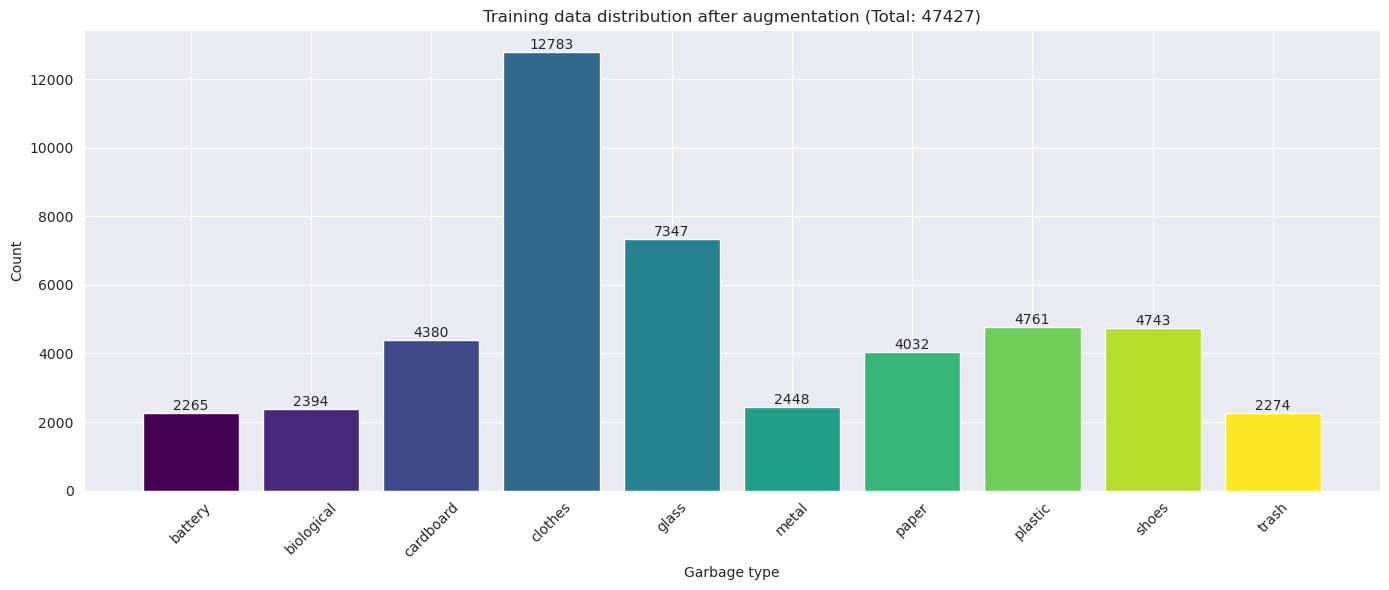

In [8]:
plt.figure(figsize=(14,6))
bars = plt.bar(class_names, counts, color=plt.cm.viridis(np.linspace(0,1,len(class_names))))
plt.title(f"Training data distribution after augmentation (Total: {len(y_train_enc)})")
plt.xlabel("Garbage type")
plt.ylabel("Count")
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height,
        s=f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.tight_layout()
plt.show()

#### Dimensionality reduction

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled  = scaler.transform(X_test_feats)

pca = PCA(n_components=300, random_state=42)
print("Number of PCA components selected:", pca.n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

Number of PCA components selected: 300


#### Training model and Prediction & Evaluation

##### SVM

In [11]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=0.5,
    gamma="scale",
    probability=False,
)

svm.fit(X_train_pca, y_train_enc)

,C,0.5
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

rf.fit(X_train_feats, y_train_enc)

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


##### Linear Regression

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver="lbfgs",
    verbose=0,
    n_jobs=-1,
)

lr.fit(X_train_pca, y_train_enc)

/home/quocha16/miniconda3/envs/Classification/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


##### Prediction & Evaluation

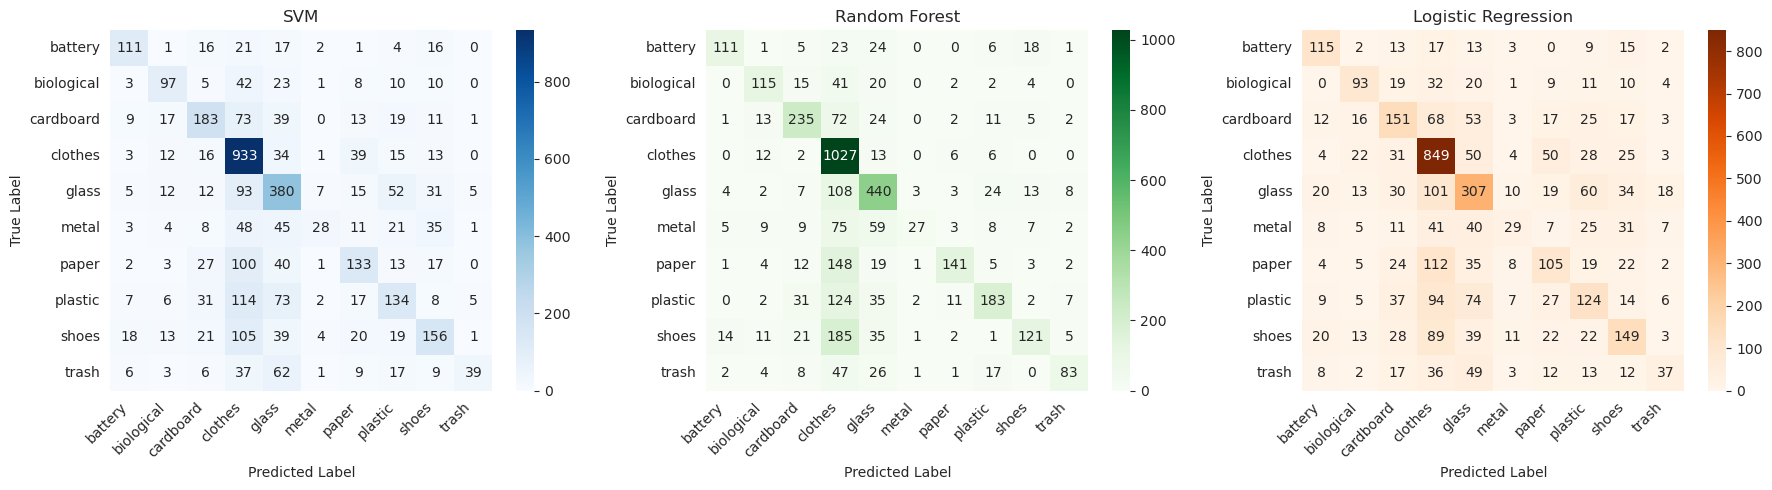

In [16]:
from sklearn.metrics import confusion_matrix

y_pred_svm = svm.predict(X_test_pca)
y_pred_rf = rf.predict(X_test_feats)
y_pred_lr = lr.predict(X_test_pca)

class_names = [
    'battery',
    'biological',
    'cardboard',
    'clothes',
    'glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash'
]

models = {
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf,
    "Logistic Regression": y_pred_lr
}

cmaps = {
    "SVM": "Blues",
    "Random Forest": "Greens",
    "Logistic Regression": "Oranges"
}

plt.figure(figsize=(18, 5))

for i, (name, y_pred) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test_enc, y_pred)

    plt.subplot(1, 3, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmaps[name],
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"{name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

##### Comparison

,Model,Accuracy,Precision,Recall,F1-score
0,SVM,0.555022,0.556176,0.555022,0.530317
1,Random Forest,0.628131,0.668454,0.628131,0.602680
2,Logistic Regression,0.495573,0.477204,0.495573,0.476213


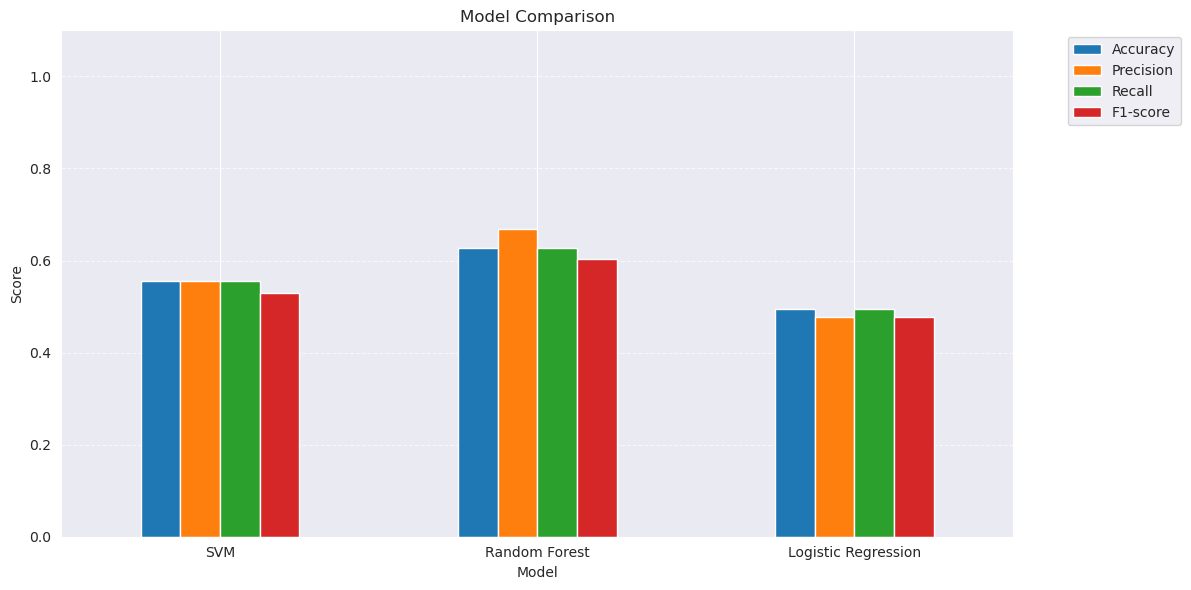

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display

model_vars = {
    "SVM": "y_pred_svm",
    "Random Forest": "y_pred_rf",
    "Logistic Regression": "y_pred_lr"
}

metrics_data = []

for model_name, var_name in model_vars.items():
    if var_name in globals():
        y_pred = globals()[var_name]
        acc = accuracy_score(y_test_enc, y_pred)
        pre = precision_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_enc, y_pred, average='weighted', zero_division=0)
        metrics_data.append([model_name, acc, pre, rec, f1])

results = pd.DataFrame(metrics_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])

display(results)

if not results.empty:
    results.set_index("Model").plot(kind="bar", figsize=(12, 6), rot=0)
    plt.title("Model Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1.1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()